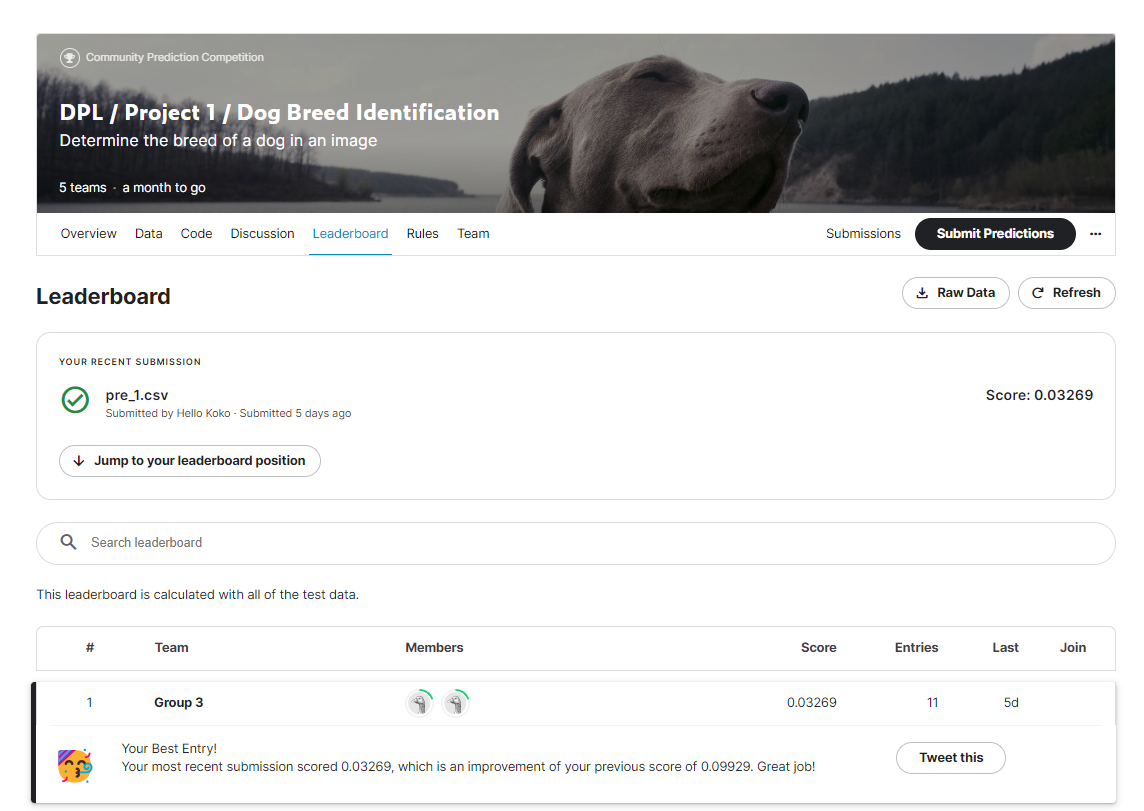

In [1]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from tqdm import tqdm

# dataset
import os
import math
import glob
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, Subset, DataLoader
import matplotlib.pyplot as plt

# save result
import pickle

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
device = torch.device("cuda:0")

print(f"Your code is running on GPU {device}.")

Your code is running on GPU cuda:0.


In [3]:
img_names = glob.glob("/kaggle/input/input-data/train/*.jpg")

print(f'Total images in Dataset : {len(img_names)}')

Total images in Dataset : 30802


In [4]:
class DogDataset(Dataset):

    def __init__(self, img_path, csv_path):
        self.csv_path = csv_path
        self.transform = None

        self.img_names = glob.glob(f"{img_path}/*.jpg")

        if csv_path:
            label_df = pd.read_csv(csv_path)
            self.label_idx2name = label_df['breed'].unique()
            self.label_name2idx = {}
            for i in range(len(self.label_idx2name)):
                self.label_name2idx[self.label_idx2name[i]] = i
            self.img2label = {}
            for _, row in label_df.iterrows():
                self.img2label[f"{img_path}/{row['id']}.jpg"] = self.label_name2idx[row['breed']]

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, index):
        img = self.img_names[index]

        if self.csv_path:
            label = self.img2label[img]
            label = torch.tensor(label)
        else:
            label = -1

        img = Image.open(img).convert("RGB")
        img = self.transform(img)
        return (img, label)

In [5]:
# transform_fn for pretrained ViT
channel_mean = torch.Tensor([0.485, 0.456, 0.406])
channel_std = torch.Tensor([0.229, 0.224, 0.225])

vit_train_transform_fn = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),

    transforms.RandomHorizontalFlip(p=0.6),
    transforms.RandomRotation(degrees=(30)),

    transforms.ToTensor(),
    transforms.Normalize(mean=channel_mean, std=channel_std),
])

vit_valid_transform_fn = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=channel_mean, std=channel_std),
])

In [6]:
dataset = DogDataset(
    img_path="/kaggle/input/input-data/train",
    csv_path="/kaggle/input/input-data/labels_new.csv",
)

In [7]:
indexes = list(range(len(dataset)))
train_indexes, valid_indexes = train_test_split(indexes, test_size=0.1)
train_dataset = Subset(dataset, train_indexes)
valid_dataset = Subset(dataset, valid_indexes)

print(f"Number of samples in train_dataset: {len(train_dataset)}")
print(f"Number of samples in valid_dataset: {len(valid_dataset)}")

Number of samples in train_dataset: 27721
Number of samples in valid_dataset: 3081


In [8]:
dataset.transform = vit_train_transform_fn
train_dataset.transform = vit_train_transform_fn
valid_dataset.transform = vit_valid_transform_fn

In [9]:
train_valid_dataloader = DataLoader(
    dataset,
    batch_size=8,
    shuffle=True
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=32,
    shuffle=True
)

In [10]:
batch_img, batch_label = next(iter(train_dataloader))

In [11]:
class PretrainViT(nn.Module):

    def __init__(self):
        super(PretrainViT, self).__init__()
        model = models.vit_l_16(pretrained=True)
        num_classifier_feature = model.heads.head.in_features
        model.heads.head = nn.Sequential(
            nn.Linear(num_classifier_feature, 120)
        )
        self.model = model

        for param in self.model.named_parameters():
            if "heads" not in param[0]:
                param[1].requires_grad = False

    def forward(self, x):
        return self.model(x)

In [12]:
net = PretrainViT()
net.to(device)
print(f"number of paramaters: {sum([param.numel() for param in net.parameters() if param.requires_grad])}")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_L_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_L_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_l_16-852ce7e3.pth" to /root/.cache/torch/hub/checkpoints/vit_l_16-852ce7e3.pth
100%|██████████| 1.13G/1.13G [00:22<00:00, 53.3MB/s]


number of paramaters: 123000


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.009, momentum=0.9)
# optimizer = optim.Adam(net.parameters())

In [14]:
def get_accuracy(output, label):
    output = output.to("cpu")
    label = label.to("cpu")

    sm = F.softmax(output, dim=1)
    _, index = torch.max(sm, dim=1)
    return torch.sum((label == index)) / label.size()[0]

In [15]:
def train(model, dataloader):
    model.train()
    running_loss = 0.0
    total_loss = 0.0
    running_acc = 0.0
    total_acc = 0.0

    for batch_idx, (batch_img, batch_label) in enumerate(dataloader):

        batch_img = batch_img.to(device)
        batch_label = batch_label.to(device)

        optimizer.zero_grad()
        output = net(batch_img)
        loss = criterion(output, batch_label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        total_loss += loss.item()

        acc = get_accuracy(output, batch_label)
        running_acc += acc
        total_acc += acc

        if batch_idx % 100 == 0 and batch_idx != 0:
            print(f"[step: {batch_idx:4d}/{len(dataloader)}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0
            running_acc = 0.0

    return total_loss / len(dataloader), total_acc / len(dataloader)

In [16]:
def validate(model, dataloader):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0

    for batch_idx, (batch_img, batch_label) in enumerate(dataloader):

        batch_img = batch_img.to(device)
        batch_label = batch_label.to(device)

        # optimizer.zero_grad()
        output = net(batch_img)
        loss = criterion(output, batch_label)
        # loss.backward()
        # optimizer.step()

        total_loss += loss.item()
        acc = get_accuracy(output, batch_label)
        total_acc += acc

    return total_loss / len(dataloader), total_acc / len(dataloader)

In [17]:
EPOCHS = 10
train_loss_history = []
valid_loss_history = []

train_acc_history = []
valid_acc_history = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train(net, train_dataloader)
    valid_loss, valid_acc = validate(net, valid_dataloader)
    print(f"Epoch: {epoch:2d}, training loss: {train_loss:.4f}, training acc: {train_acc:.4f} validation loss: {valid_loss:.4f}, validation acc: {valid_acc:.4f}")

    train_loss_history.append(train_loss)
    valid_loss_history.append(valid_loss)

    train_acc_history.append(train_acc)
    valid_acc_history.append(valid_acc)

    if valid_loss <= min(valid_loss_history):
        torch.save(net.state_dict(), "net.pt")

[step:  100/3466] loss: 2.489
[step:  200/3466] loss: 0.490
[step:  300/3466] loss: 0.197
[step:  400/3466] loss: 0.210
[step:  500/3466] loss: 0.175
[step:  600/3466] loss: 0.144
[step:  700/3466] loss: 0.170
[step:  800/3466] loss: 0.132
[step:  900/3466] loss: 0.147
[step: 1000/3466] loss: 0.154
[step: 1100/3466] loss: 0.141
[step: 1200/3466] loss: 0.085
[step: 1300/3466] loss: 0.144
[step: 1400/3466] loss: 0.111
[step: 1500/3466] loss: 0.096
[step: 1600/3466] loss: 0.107
[step: 1700/3466] loss: 0.114
[step: 1800/3466] loss: 0.091
[step: 1900/3466] loss: 0.119
[step: 2000/3466] loss: 0.135
[step: 2100/3466] loss: 0.083
[step: 2200/3466] loss: 0.110
[step: 2300/3466] loss: 0.096
[step: 2400/3466] loss: 0.119
[step: 2500/3466] loss: 0.130
[step: 2600/3466] loss: 0.099
[step: 2700/3466] loss: 0.102
[step: 2800/3466] loss: 0.103
[step: 2900/3466] loss: 0.088
[step: 3000/3466] loss: 0.098
[step: 3100/3466] loss: 0.075
[step: 3200/3466] loss: 0.109
[step: 3300/3466] loss: 0.106
[step: 340

In [18]:
net = PretrainViT()
net.load_state_dict(torch.load("./net.pt", map_location="cpu"))
net.to(device)
net.eval()

PretrainViT(
  (model): VisionTransformer(
    (conv_proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=1024, out_features=4096, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=4096, out_features=1024, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln_

In [25]:
class TestDataset(Dataset):

    def __init__(self, test_names, transform_fn):
        self.test_names = test_names
        self.transform = transform_fn

    def __len__(self):
        return len(self.test_names)

    def __getitem__(self, idx):
        name = self.test_names[idx]
        path = os.path.join("/kaggle/input/input-data/test", name + ".jpg")
        img = Image.open(path)
        img = self.transform(img)
        return (img, name)

In [21]:
submit_df = pd.read_csv("/kaggle/input/input-data/sample_submission.csv")
test_names = submit_df["id"].values
columns = list(dataset.label_idx2name)

In [23]:
dataset = TestDataset(
    test_names = test_names,
    transform_fn = vit_valid_transform_fn
)

In [24]:
test_dataloader = DataLoader(
    dataset=dataset,
    batch_size=64,
    shuffle=False
)

In [26]:
len(columns)

120

In [27]:
with torch.no_grad():

    dfs = []

    for batch_idx, (batch_img, batch_name) in tqdm(enumerate(test_dataloader)):
        df = pd.DataFrame(columns=["id"] + columns)
        df["id"] = batch_name

        batch_img = batch_img.to(device)
        output = net(batch_img)
        sm = F.softmax(output, dim=1)
        df[columns] = sm.cpu().numpy()
        dfs.append(df)

162it [06:03,  2.24s/it]


In [28]:
my_submit = pd.concat(dfs)

In [29]:
my_submit.to_csv("pre_1.csv", index=False)